In [2]:
import matplotlib.pyplot as plt
import numpy as np
import statistics
import pandas as pd
import math
import random
import csv
import sys

from scipy.stats import wasserstein_distance

In [384]:
import requests

def get_quantum_numbers(api_key, length, data_type, block_size=None):
    # Base URL of the API
    #return
    API_URL = "https://api.quantumnumbers.anu.edu.au"

    # Prepare parameters
    params = {
        'length': length,
        'type': data_type
    }
    if block_size and data_type in ['hex8', 'hex16']:
        params['size'] = block_size

    # Headers including your API key
    headers = {'x-api-key': api_key}

    # Send GET request to the API
    response = requests.get(API_URL, headers=headers, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        print("\n\n\nAPI USEEED\n\n\n")
        return response.json()
    else:
        return f"Error: {response.status_code}"

In [385]:
def read_dataset(file_path):
    dataset = pd.read_csv(file_path)
    return dataset

def get_filtered_data(dataset, country, year):
    return dataset.query("Country == @country and dt.str.contains(@year)")

def get_histogram(dataset, country='Turkey', year='2010'):
    filtered_data = dataset.query("Country == @country and dt.str.contains(@year)")
    avg_temperatures = filtered_data["AverageTemperature"].to_list()
    # plt.bar(filtered_data["dt"], avg_temperatures)
    # plt.xticks(rotation=60)
    # plt.title('Average Temperature Case for Country ' + country + ' in year ' + year)
    # plt.show()

    return avg_temperatures
def python_random_laplace(loc, scale, size=1):
    samples = []

    for _ in range(size):
        U = np.random.uniform()

        if U >= 0.5:
            sample = loc - scale * np.log(2.0 - 2.0 * U)
        else:
            sample = loc + scale * np.log(2.0 * U)

        samples.append(sample)

    return np.array(samples)

def quantum_random_laplace(loc, scale, size=1):
    #return python_random_laplace(loc, scale, size)
    samples = []
    api_key = '6D3iAkBhbT2SQ3Ao8mlvM6DFUzUys7f57vP56QSa'

    if 1 <= size <= 1024:
        json = get_quantum_numbers(api_key, length=size, data_type='uint8')
        quantum_data = json['data']
    else:
        print("Random number size should be between 1 and 1024")
        sys.exit()

    samples = []
    # Scale the quantum data to the range [0, 1]
    scaled_data = [x / 255.0 for x in quantum_data]

    for U in scaled_data:
        if U >= 0.5:
            sample = loc - scale * np.log(2.0 - 2.0 * U)
        else:
            sample = loc + scale * np.log(2.0 * U)
        samples.append(sample)

        return np.array(samples)

def get_pseudorandom_dp_histogram(dataset, country, year, epsilon, N):
    filtered_data = dataset.query(f"Country == '{country}' and dt.str.contains('{year}')")
    avg_temperatures = filtered_data["AverageTemperature"].values
    sensitivity = N
    laplace_noise = python_random_laplace(loc=0, scale=sensitivity / epsilon, size=len(avg_temperatures))
    noisy_data = avg_temperatures + laplace_noise


    return noisy_data

def get_true_random_dp_histogram(dataset, country, year, epsilon, N):
    filtered_data = dataset.query(f"Country == '{country}' and dt.str.contains('{year}')")
    avg_temperatures = filtered_data["AverageTemperature"].values
    sensitivity = N
    quantum_laplace_noise =quantum_random_laplace(loc=0,scale=sensitivity / epsilon, size=len(avg_temperatures))
    noisy_data = avg_temperatures + quantum_laplace_noise


    return noisy_data

def country_year_query(country, year, epsilon_budget = 1):
    filename = "GlobalLandTemperaturesByCountry.csv"
    dataset = read_dataset(filename)

    country = country.title() # Capitalizes first letter

    # Transform numpy arrays to lists. 
    avg_temperatures_real = np.array(get_histogram(dataset,country,year))
    avg_temperatures_dp = get_pseudorandom_dp_histogram(dataset, country, year,epsilon_budget,76/12)
    avg_temperatures_quantum_dp = get_true_random_dp_histogram(dataset, country, year,epsilon_budget,76/12)

    return [avg_temperatures_real, avg_temperatures_dp, avg_temperatures_quantum_dp], get_filtered_data(dataset,country,year)["dt"].values

## Returns Earth Mover Distances between pairs of original, pseudo and real.
def get_errors_between(original, pseudo, real):
    e1 = wasserstein_distance(original, pseudo)
    e2 = wasserstein_distance(original, real)
    e3 = wasserstein_distance(real, pseudo)

    return [e1, e2, e3]

In [386]:
filename = "GlobalLandTemperaturesByCountry.csv"
dataset = read_dataset(filename)

country = "Japan"
year = "2012"
epsilon = 2
average_index = 20

In [400]:
def graph(dates, original, pseudo, real, country, year):
    bar_width = 0.2
    bar_positions = np.arange(len(dates)) 

    plt.bar(bar_positions - bar_width, original, width=bar_width, label='Original', color='blue')
    plt.bar(bar_positions, pseudo, width=bar_width, label='Pseudo', color='orange')
    plt.bar(bar_positions + bar_width, real, width=bar_width, label='True', color='green')

    plt.xticks(bar_positions, dates, rotation=60)
    plt.title(f'Average Temperature Case for {country} in {year}')
    plt.legend()
    plt.show()
    
def graph_errors(dop, dor, dpr):
    plt.plot(dop, label='Distance Original Pseudo', color='blue', linestyle='-')
    plt.plot(dor, label='Distance Original True', color='green', linestyle='-')
    plt.plot(dpr, label='Distance Pseudo True', color='red', linestyle='-')

    plt.title(f'Rolling Average of Distances between Original, Pseudo and True versus Iteration')
    plt.xticks(range(len(dop)))
    plt.legend()
    plt.show()
    
def graph_yearly(dop, dor, dpr, country):
    plt.plot(dop, label='No Noise', color='blue', linestyle='-')
    plt.plot(dor, label='Pseudo Noise', color='green', linestyle='-')
    plt.plot(dpr, label='True Noise', color='red', linestyle='-')

    plt.title(f'Yearly values for Query for {country}')
    plt.legend()
    plt.show()

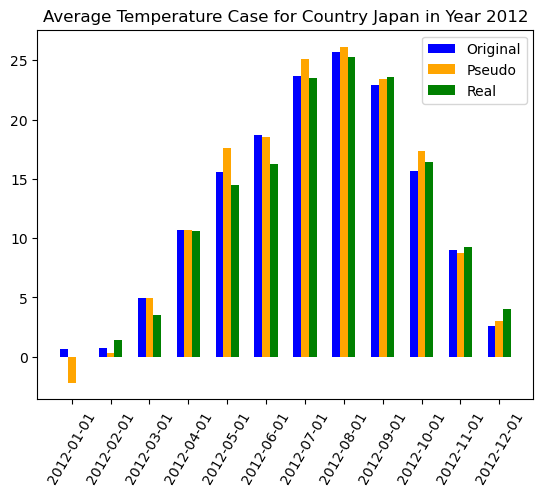

In [346]:
#data, dates = country_year_query(country,year, epsilon)
#graph(dates, *data, country, year)

In [369]:
import time

In [389]:
data, dates = country_year_query(country,year, epsilon)

pd.DataFrame(data).to_csv(f"query_0.csv")

data = np.array(data)
errors = [[],[],[]]
for i in range(1,average_index):
    print(f"Iteration: {i}\n")
    result = country_year_query(country,year, epsilon)[0]
    data += result
    
    pd.DataFrame(result).to_csv(f"query_{i}.csv")
    
    dop, dor, drp = get_errors_between( *(data/i) )
    errors[0].append(dop)
    errors[1].append(dor)
    errors[2].append(drp)
    
    time.sleep(1)

pd.DataFrame(data).to_csv(f"Average20.csv")
data = data/average_index




API USEEED



Iteration: 1




API USEEED



Iteration: 2




API USEEED



Iteration: 3




API USEEED



Iteration: 4




API USEEED



Iteration: 5




API USEEED



Iteration: 6




API USEEED



Iteration: 7




API USEEED



Iteration: 8




API USEEED



Iteration: 9




API USEEED



Iteration: 10




API USEEED



Iteration: 11




API USEEED



Iteration: 12




API USEEED



Iteration: 13




API USEEED



Iteration: 14




API USEEED



Iteration: 15




API USEEED



Iteration: 16




API USEEED



Iteration: 17




API USEEED



Iteration: 18




API USEEED



Iteration: 19




API USEEED





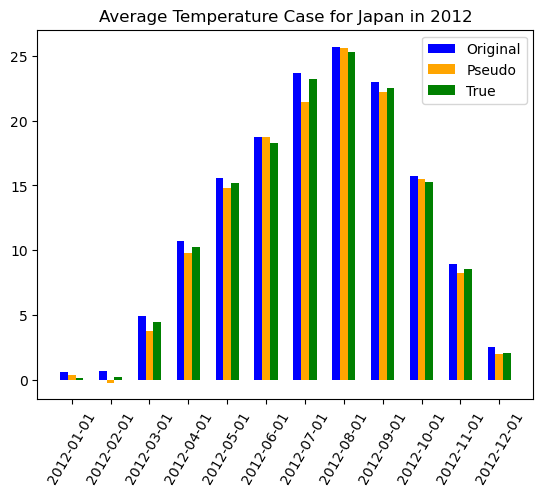

In [401]:
graph(dates, *data, country, year)

In [412]:
nperrors[1]

array([6.27068863e+00, 3.61797849e+00, 1.97603984e-03, 6.08559616e-01,
       1.44884501e+00, 1.28528984e+00, 1.09989947e+00, 1.05463956e+00,
       1.40251963e+00, 1.31482963e+00, 1.14483810e+00, 1.03122847e+00,
       5.34726015e-01, 6.07683004e-01, 5.17982792e-01, 4.50916544e-01,
       7.13542144e-01, 4.65507028e-01, 4.59659644e-01])

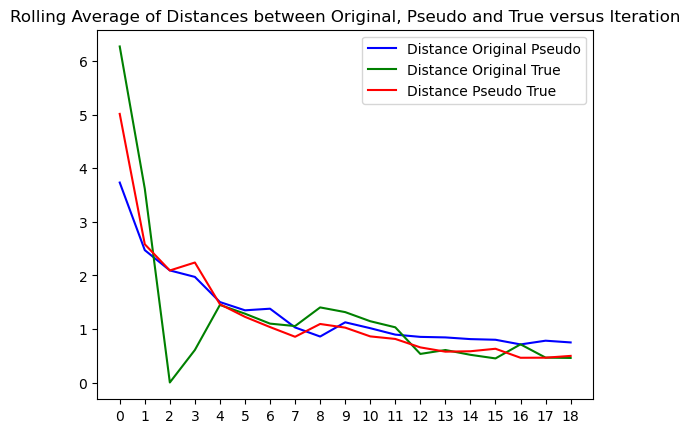

In [402]:
nperrors = np.array(errors)#.reshape(3,-1)
graph_errors( *nperrors )

In [419]:
dataset['year']

0         1743
1         1743
2         1744
3         1744
4         1744
          ... 
577457    2013
577458    2013
577459    2013
577460    2013
577461    2013
Name: year, Length: 577462, dtype: object

# Workable Year Queries

In [414]:
filename = "GlobalLandTemperaturesByCountry.csv"
dataset = read_dataset(filename)
dataset['year'] = dataset['dt'].str[:4]
dataset['month'] = dataset['dt'].str[5:7]

df = dataset.loc[dataset["Country"] == country]

query_max = df.groupby(['year'])['AverageTemperature'].max()
query_median = df.groupby(['year'])['AverageTemperature'].median()
query_mean = df.groupby(['year'])['AverageTemperature'].mean()
query_min = df.groupby(['year'])['AverageTemperature'].min()

In [420]:
def get_noised(query, epsilon, sensitivity):
    laplace_noise = python_random_laplace(loc=0, scale=sensitivity / epsilon, size=len(query))
    quantum_laplace_noise = quantum_random_laplace(loc=0,scale=sensitivity / epsilon, size=len(query))
    print(f"\nNOISING LOG: \n\tSCALE:{sensitivity/epsilon}\n\tMAX:{max(laplace_noise)}, {max(quantum_laplace_noise)}")
    pseudo = query + laplace_noise
    true = query + quantum_laplace_noise
    
    return [pseudo, true]

def get_yearly_all(country, epsilon):
    filename = "GlobalLandTemperaturesByCountry.csv"
    dataset = read_dataset(filename)
    
    dataset['year'] = dataset['dt'].str[:4]
    dataset['month'] = dataset['dt'].str[5:7]

    df = dataset.loc[dataset["Country"] == country.title()]

    query_max = df.groupby(['year'])['AverageTemperature'].max()
    query_median = df.groupby(['year'])['AverageTemperature'].median()
    query_mean = df.groupby(['year'])['AverageTemperature'].mean()
    query_min = df.groupby(['year'])['AverageTemperature'].min()
    
    noised_max = get_noised(query_max, epsilon, 76)
    noised_median = get_noised(query_median, epsilon, 76)
    noised_mean = get_noised(query_mean, 1, 76/len(query_mean))
    noised_min = get_noised(query_min, epsilon, 76)
    
    return [[query_max, *noised_max], [query_median, *noised_median],[query_mean, *noised_mean],[query_min, *noised_min]]
    

In [421]:
queries = get_yearly_all(country, 40)




API USEEED




NOISING LOG: 
	SCALE:1.9
	MAX:9.112944083056005, 1.400760750807822



API USEEED




NOISING LOG: 
	SCALE:1.9
	MAX:8.349572350843886, 0.9336743220268892



API USEEED




NOISING LOG: 
	SCALE:0.4393063583815029
	MAX:1.9387367750753621, 0.005198952492324928



API USEEED




NOISING LOG: 
	SCALE:1.9
	MAX:9.84248711209569, 7.8944414496732245


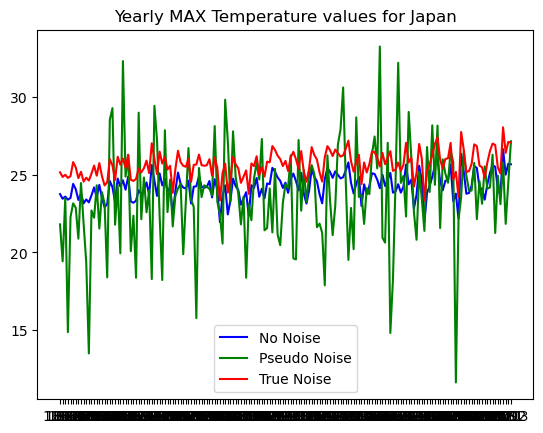

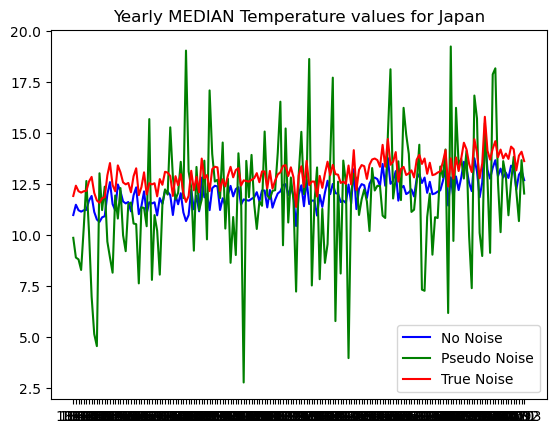

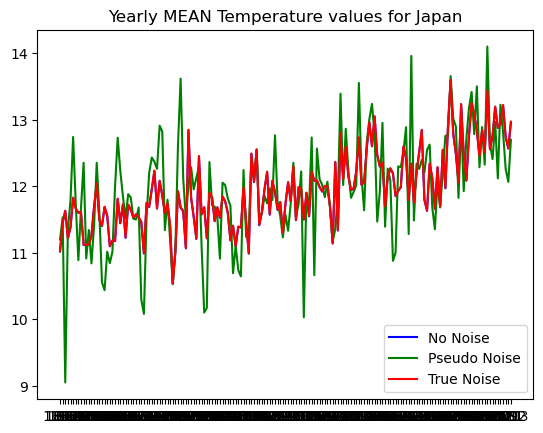

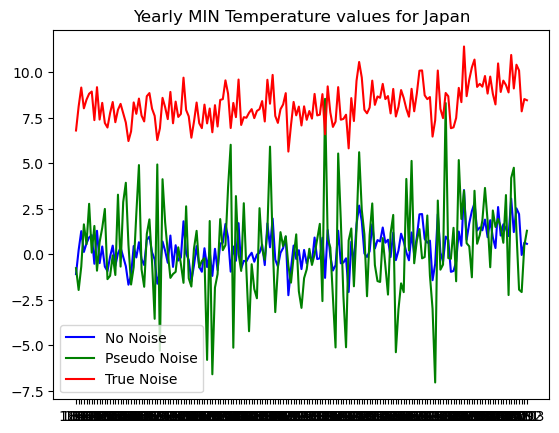

In [431]:
graph_yearly(*queries[0], country, "MAX Temperature")
graph_yearly(*queries[1], country, "MEDIAN Temperature")
graph_yearly(*queries[2], country, "MEAN Temperature")
graph_yearly(*queries[3], country, "MIN Temperature")